In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

In [2]:
inflows = pd.read_parquet('C:/Users/bdion/Downloads/DSC180A/DSC180A/data/ucsd-inflows.pqt')
outflows = pd.read_parquet('C:/Users/bdion/Downloads/DSC180A/DSC180A/data/ucsd-outflows.pqt')

inflows.posted_date  = pd.to_datetime(inflows.posted_date, format='%Y-%m-%d')
outflows.posted_date = pd.to_datetime(outflows.posted_date, format='%Y-%m-%d')

## Data Cleaning:

In [3]:
outflows['new_memo'] = outflows.memo.str.lower().str.replace(r'\*(\S)', r' \1', regex=True)     # Remove all '*' but gotta check if there's any alphanumerics right after it
outflows['new_memo'] = outflows.new_memo.str.replace(r'[^a-z0-9]', ' ', regex=True)             # Remove all special chars
outflows['new_memo'] = outflows.new_memo.str.replace(r'x{3,}', ' ', regex=True)                 # Remove all triple X's
outflows['new_memo'] = outflows.new_memo.str.replace(r'withdrawal', 'withdrawal ', regex=True)  # Fixing the withdrawal rows
outflows['new_memo'] = outflows.new_memo.str.replace(r'\s+', ' ', regex=True).str.strip()       # Remove any extra whitespace

outflows = outflows[['prism_consumer_id', 'prism_account_id', 'memo', 'new_memo', 'amount',	'posted_date', 'category']]
outflows[['memo', 'new_memo']]

,memo,new_memo
0,LOAN,loan
1,ATM_CASH,atm cash
2,TST* Casa Del Rio - Exp Fairlawn OH 09/24,tst casa del rio exp fairlawn oh 09 24
3,LOAN,loan
4,Buffalo Wild Wings,buffalo wild wings
...,...,...
2597483,ATM_CASH,atm cash
2597484,ATM_CASH,atm cash
2597485,ATM_CASH,atm cash
2597486,ATM_CASH,atm cash


In [4]:
outflows.drop(columns='memo', inplace=True)

## Data Splitting:

In [5]:
np.random.seed(42069)

# Splitting based on prism_consumer_id:
cids = outflows.prism_consumer_id.unique()
train_cids, test_cids = train_test_split(cids, test_size=0.3, random_state=420) # 70 / 30 split

# Features and labels for train and test sets:
X_train = outflows[outflows.prism_consumer_id.isin(train_cids)]
y_train = X_train.category
X_test  = outflows[outflows.prism_consumer_id.isin(test_cids)]
y_test  = X_test.category

X_train = X_train.drop(columns='category')
X_test = X_test.drop(columns='category')

len(X_train), len(X_test)

(1780156, 817332)

## Logistic Regression Model:

- Just using tf-idf feats:

In [7]:
preproc_base = ColumnTransformer(
    transformers=
    [
        ('tf-idf', TfidfVectorizer(max_features=1000), 'new_memo')
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preproc_base),
    ('classifier', LogisticRegression())
])

In [8]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_train)

print(classification_report(y_train.values.flatten(), y_pred))

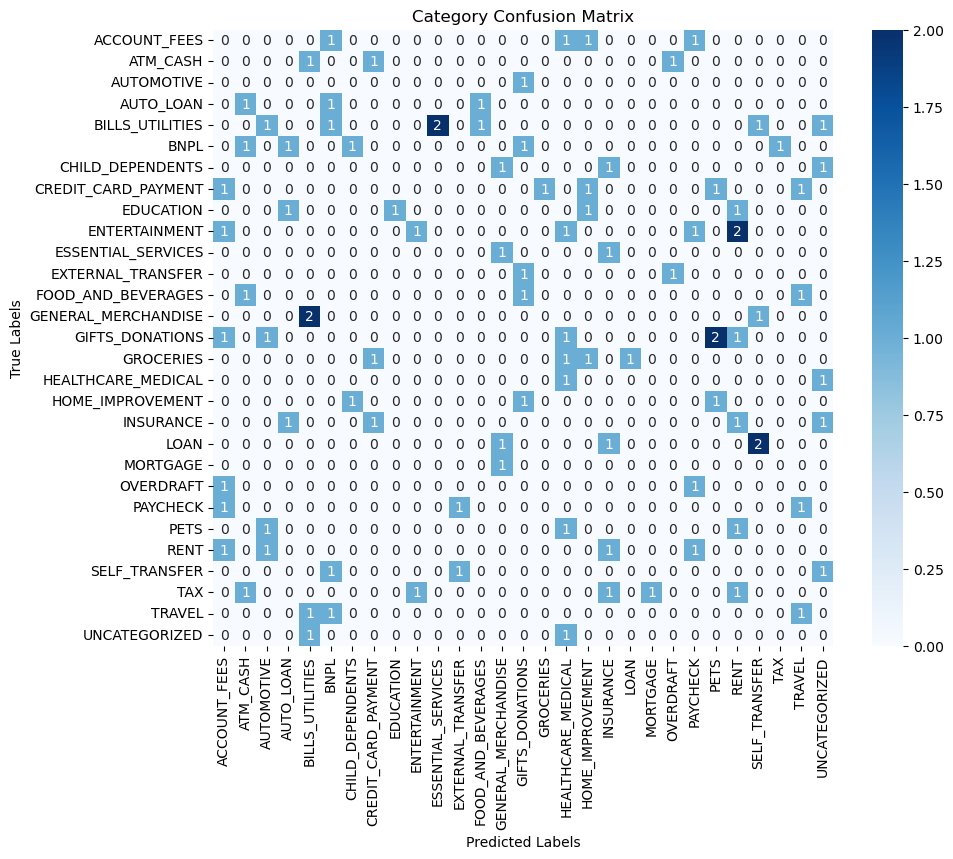

In [9]:
label_classes = np.unique(y_train)
true_labels = np.random.choice(label_classes, 100)
predicted_labels = np.random.choice(label_classes, 100)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=label_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_classes, yticklabels=label_classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Category Confusion Matrix")
plt.show()

In [10]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test.values.flatten(), y_pred))

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

       ACCOUNT_FEES       1.00      1.00      1.00     12248
           ATM_CASH       1.00      1.00      1.00     36855
         AUTOMOTIVE       1.00      1.00      1.00     66575
               BNPL       1.00      1.00      1.00       680
   CHILD_DEPENDENTS       0.00      0.00      0.00       578
CREDIT_CARD_PAYMENT       1.00      1.00      1.00     24202
          EDUCATION       0.80      0.40      0.53      1443
      ENTERTAINMENT       1.00      1.00      1.00     26093
 ESSENTIAL_SERVICES       1.00      1.00      1.00     25099
  EXTERNAL_TRANSFER       1.00      1.00      1.00    103326
 FOOD_AND_BEVERAGES       0.86      0.94      0.89    152218
GENERAL_MERCHANDISE       0.92      0.90      0.91    164054
    GIFTS_DONATIONS       1.00      1.00      1.00      1605
          GROCERIES       0.95      0.90      0.92     68553
 HEALTHCARE_MEDICAL       1.00      1.00      1.00     12600
   HOME_IMPROVEMENT    

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


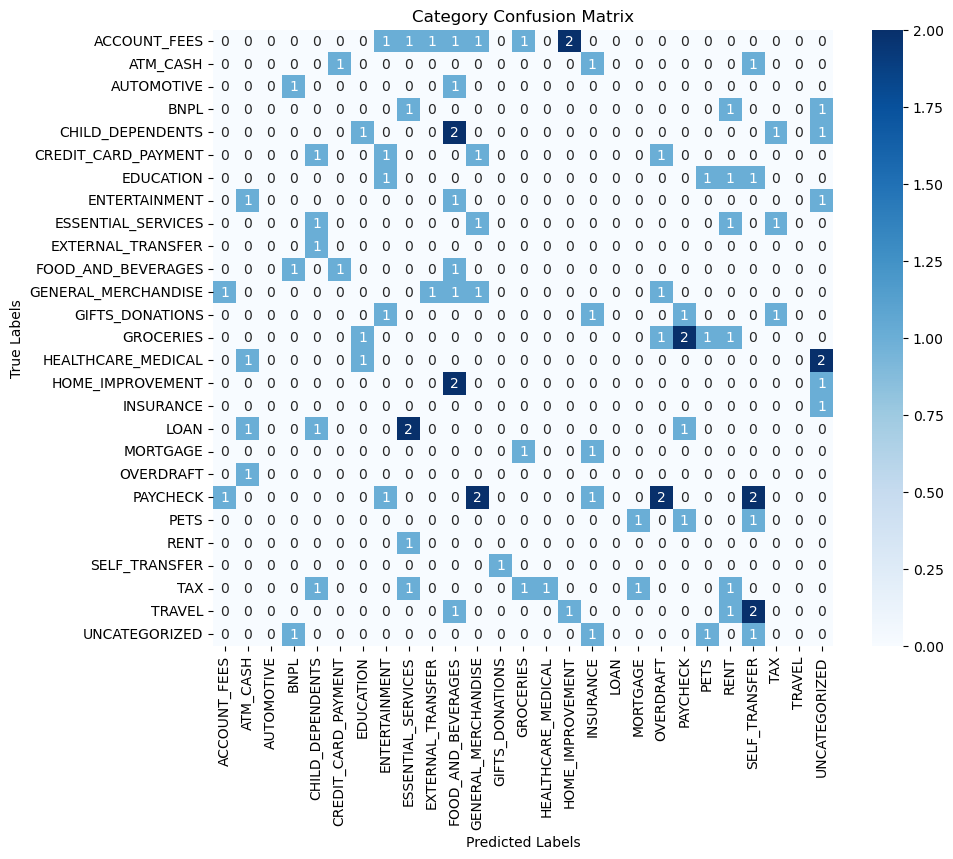

In [11]:
label_classes = np.unique(y_test)
true_labels = np.random.choice(label_classes, 100)
predicted_labels = np.random.choice(label_classes, 100)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=label_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_classes, yticklabels=label_classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Category Confusion Matrix")
plt.show()

## Feature Engineering:

In [16]:
def is_whole_number(X):
    return (X % 1 == 0).to_frame(name='is_whole')

## Random-Forest Model:

In [17]:
def extract_month(X):
    X = X.copy()
    return X.dt.month_name().to_frame(name='posted_date_month')

def extract_day(X):
    X = X.copy()
    return X.dt.day_name().to_frame(name='posted_date_day')

def extract_weekend(X):
    X = X.copy()
    return (X.dt.dayofweek >= 5).astype(int).to_frame(name='posted_date_weekend')

# Define the ColumnTransformer
preproc_final = ColumnTransformer(
    transformers=[
        ('whole_num', FunctionTransformer(is_whole_number), 'amount'),
        ('date_month', Pipeline([
            ('extract_month', FunctionTransformer(extract_month)),
            ('one-hot', OneHotEncoder())
        ]), 'posted_date'),
        ('date_day', Pipeline([
            ('extract_day', FunctionTransformer(extract_day)),
            ('one-hot', OneHotEncoder())
        ]), 'posted_date'),
        ('date_weekend', FunctionTransformer(extract_weekend), 'posted_date'),
        ('tf-idf', TfidfVectorizer(max_features=1000), 'new_memo')
    ],
    remainder='drop'
)

# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', preproc_final),
    ('classifier', RandomForestClassifier(random_state=42069))
])

In [18]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_train)

print(classification_report(y_train.values.flatten(), y_pred))

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

       ACCOUNT_FEES       1.00      1.00      1.00     25263
           ATM_CASH       1.00      1.00      1.00     80796
         AUTOMOTIVE       1.00      1.00      1.00    142004
          AUTO_LOAN       1.00      1.00      1.00         1
    BILLS_UTILITIES       0.00      0.00      0.00        23
               BNPL       1.00      1.00      1.00       863
   CHILD_DEPENDENTS       0.00      0.00      0.00       358
CREDIT_CARD_PAYMENT       1.00      1.00      1.00     51304
          EDUCATION       0.98      0.80      0.88      3056
      ENTERTAINMENT       1.00      1.00      1.00     54792
 ESSENTIAL_SERVICES       1.00      1.00      1.00     52038
  EXTERNAL_TRANSFER       1.00      1.00      1.00    217672
 FOOD_AND_BEVERAGES       0.95      0.99      0.97    329776
GENERAL_MERCHANDISE       0.99      0.97      0.98    360009
    GIFTS_DONATIONS       1.00      1.00      1.00      3114
          GROCERIES    

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


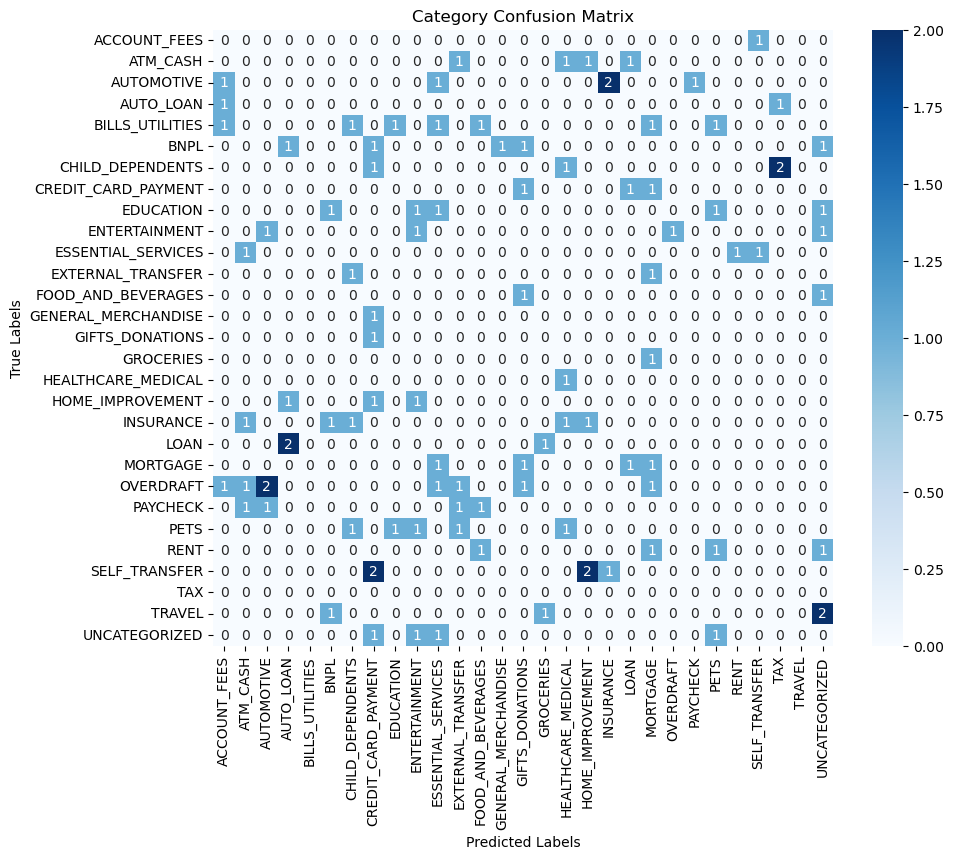

In [19]:
label_classes = np.unique(y_train)
true_labels = np.random.choice(label_classes, 100)
predicted_labels = np.random.choice(label_classes, 100)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=label_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_classes, yticklabels=label_classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Category Confusion Matrix")
plt.show()

In [20]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test.values.flatten(), y_pred))

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

       ACCOUNT_FEES       1.00      1.00      1.00     12248
           ATM_CASH       1.00      1.00      1.00     36855
         AUTOMOTIVE       1.00      1.00      1.00     66575
               BNPL       1.00      1.00      1.00       680
   CHILD_DEPENDENTS       0.00      0.00      0.00       578
CREDIT_CARD_PAYMENT       1.00      1.00      1.00     24202
          EDUCATION       0.71      0.31      0.43      1443
      ENTERTAINMENT       1.00      1.00      1.00     26093
 ESSENTIAL_SERVICES       1.00      1.00      1.00     25099
  EXTERNAL_TRANSFER       1.00      1.00      1.00    103326
 FOOD_AND_BEVERAGES       0.84      0.93      0.89    152218
GENERAL_MERCHANDISE       0.92      0.89      0.90    164054
    GIFTS_DONATIONS       1.00      1.00      1.00      1605
          GROCERIES       0.95      0.89      0.92     68553
 HEALTHCARE_MEDICAL       1.00      1.00      1.00     12600
   HOME_IMPROVEMENT    

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


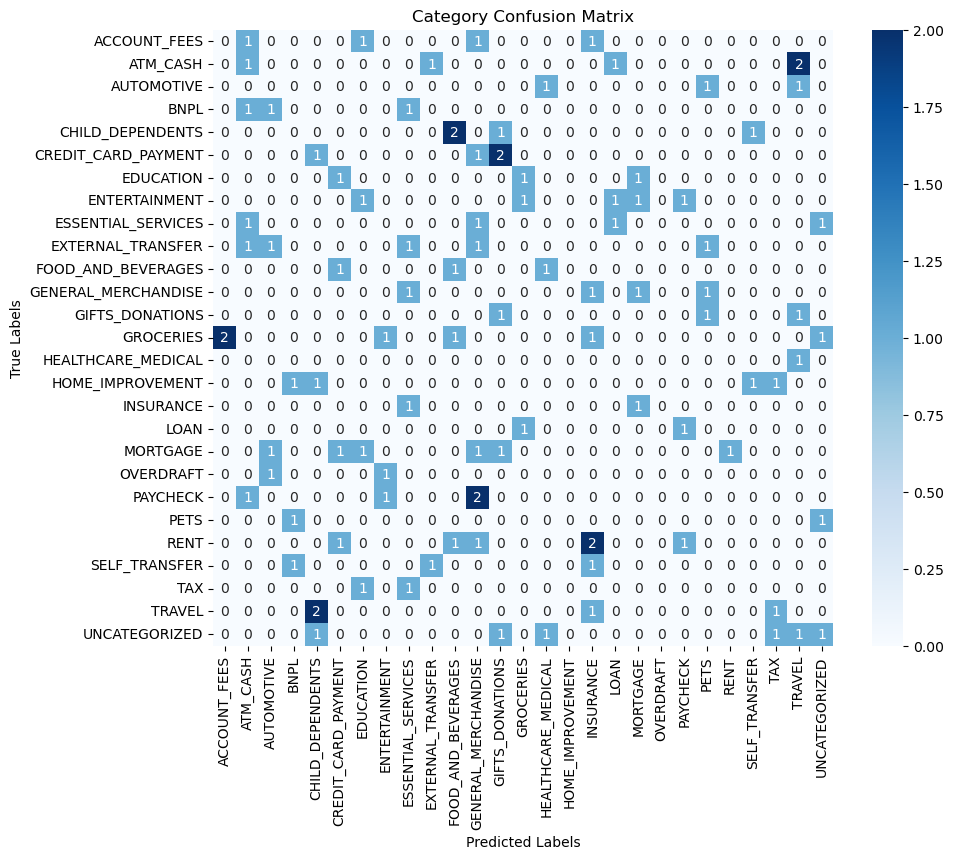

In [21]:
label_classes = np.unique(y_test)
true_labels = np.random.choice(label_classes, 100)
predicted_labels = np.random.choice(label_classes, 100)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=label_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_classes, yticklabels=label_classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Category Confusion Matrix")
plt.show()